This notebook extends the structures of the example 0, for basic gradient descent with linear regression, to support multiple features.

#### Tools
- NumPy, library for scientific computing, used to work with vectorised features (x1 ... xn) and parameters (w1 ... wn)
- Matplotlib, plotting library, for when examples have to be showcased in a graphical, more visual and intuitive, manner.
Below said libraries are imported

In [4]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

#### Notation Used
The following is conventional notation used for this algorithm (and associated model):

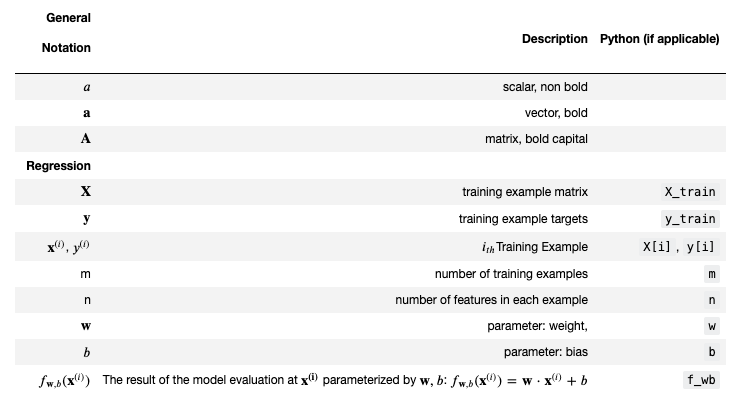

<a name="toc_15456_2"></a>
# 2 Problem Statement

This lab uses an example of housing price prediction. The training dataset contains 3 examples with 4 features (size, bedrooms, floors and, age) shown in the table below.  Note size is in sqft rather than 1000s sqft. This causes an issue, to be solved in lab "2".

| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |  

This lab builds a linear regression model using these values to predict the price for other houses. For example, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old.  

Below code cell creates `X_train` and `y_train` variables.

In [5]:
X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
y_train = np.array([460, 232, 178])

The following is a scatter plot for these values; however, plotting multiple features for multilinear regression can be a bit challenging, especially when dealing with more than two features because we live in a 3D world and visualizing data in higher dimensions can be complex. However, we can still create scatter plots to visualize the relationship between each pair of features.

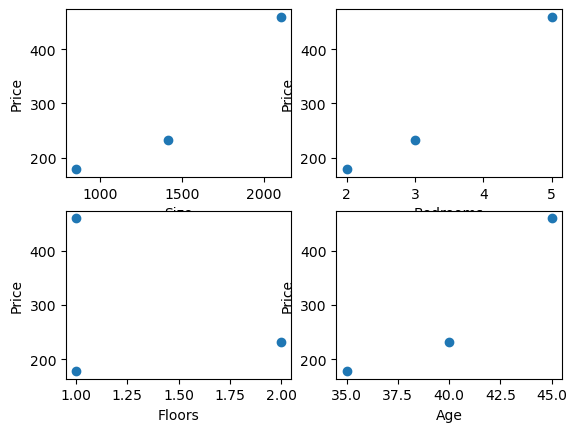

In [6]:
# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Plot Size vs Price
axs[0, 0].scatter(X_train[:, 0], y_train)
axs[0, 0].set_xlabel('Size')
axs[0, 0].set_ylabel('Price')

# Plot Bedrooms vs Price
axs[0, 1].scatter(X_train[:, 1], y_train)
axs[0, 1].set_xlabel('Bedrooms')
axs[0, 1].set_ylabel('Price')

# Plot Floors vs Price
axs[1, 0].scatter(X_train[:, 2], y_train)
axs[1, 0].set_xlabel('Floors')
axs[1, 0].set_ylabel('Price')

# Plot Age vs Price
axs[1, 1].scatter(X_train[:, 3], y_train)
axs[1, 1].set_xlabel('Age')
axs[1, 1].set_ylabel('Price')

plt.show()

### Examples Matrix
The matrix of examples represents Features (columns) per Example (rows). These are stored in a NumPy array of 2 dimensions (the matrix). Each row of the matrix represents one example. When you have $m$ training examples ( $m$ is three in our example), and there are $n$ features (four in our example), $\mathbf{X}$ is a matrix with dimensions ($m$, $n$) (m rows, n columns).

$$\mathbf{X} = 
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\ 
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1} 
\end{pmatrix}
$$
notation:
- $\mathbf{x}^{(i)}$ is vector containing example i. $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$ is element j in example i. The superscript in parenthesis indicates the example number while the subscript represents an element.  

Display the input data.

In [7]:
# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(X_train)
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train)

X Shape: (3, 4), X Type:<class 'numpy.ndarray'>)
[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]
y Shape: (3,), y Type:<class 'numpy.ndarray'>)
[460 232 178]


### Parameters Vector
* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - in our dataset, n is 4.
  - notionally, we draw this as a column vector

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ is a scalar parameter. 

For demonstration, $\mathbf{w}$ and $b$ will be loaded with some initial selected values that are near the optimal. $\mathbf{w}$ is a 1-D NumPy vector.

In [8]:
b_init = 785.18
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


### Model Prediction with Multiple Variables
The model's prediction with multiple variables is given by the linear model:
$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`
The prediction will be implemented using (1) and (2).

<a name="toc_15456_3.1"></a>
## Single Prediction element by element
The previous prediction (notebook '0') multiplied one feature value by one parameter and added a bias parameter. A direct extension of this previous implementation of prediction to multiple features would be to implement (1) above using loop over each element, performing the multiply with its parameter and then adding the bias parameter at the end.

In [9]:
def predict_single_loop(x, w, b):
    """
    Single predict using linear regression
    
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters    
      b (scalar):  model parameter     
      
    Returns:
      p (scalar):  prediction
    """
    n = x.shape[0]
    # Prediction
    p = 0
    for i in range(n):
      p += w[i] * x[i]
    p += b
    return p

And below code snippet does a quick sanity check on this function just defined

In [10]:
# Get a row from the training set (matrix), first in this case
x_1 = X_train[0]
print(f"x vector shape {x_1.shape}, x vector value: {x_1}")
# Use some pre-calculated optimal values for the parameters and the bias, in conjunction with this training set's row
f_wb = predict_single_loop(x_1, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb} - Target (y) for first vector row: {y_train[0]}")

x vector shape (4,), x vector value: [2104    5    1   45]
f_wb shape (), prediction: 459.99886082 - Target (y) for first vector row: 460


<a name="toc_15456_3.1"></a>
## Single Prediction - Vectorized
Making use of NumPy for vector operations is a huge improvement in terms of code conciseness and run times/performance. This is achieved in the code as following:

In [11]:
def predict(x, w, b):
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    p = np.dot(x, w) + b
    return p    

The same prediction as above can be used for demonstration purposes

In [12]:
# Get a row from the training set (matrix), first in this case
x_1 = X_train[0]
print(f"x vector shape {x_1.shape}, x vector value: {x_1}")
# Use some pre-calculated optimal values for the parameters and the bias, in conjunction with this training set's row
f_wb = predict(x_1, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb} - Target (y) for first vector row: {y_train[0]}")

x vector shape (4,), x vector value: [2104    5    1   45]
f_wb shape (), prediction: 459.99886082 - Target (y) for first vector row: 460


<a name="toc_15456_3.1"></a>
## Cost Compute with Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


In contrast to previous notebooks, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

Recall from the notations, that bold characters are vectors, and capital bold a matrix

Below is an implementation of equations (3) and (4). Note that this uses a *standard pattern for this course* where a for loop over all `m` examples is used.

In [13]:
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    # Calculates total cost, per each array for specific choices of 'w's parameters and biased 'b'
    for i in range(m):
        f_wb = predict(X[i], w, b)
        cost = cost + (f_wb - y[i]) ** 2
    cost /= (2 * m)
    return cost

In [14]:
# Compute and display cost using pre-chosen optimal parameters. 
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 6.480609223666217e-07


<a name="toc_15456_5"></a>
# Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value

An implementation for calculating the equations (6) and (7) is below. There are many ways to implement this. In this version, there is an
- outer loop over all m examples. 
    - $\frac{\partial J(\mathbf{w},b)}{\partial b}$ for the example can be computed directly and accumulated
    - in a second loop over all n features:
        - $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ is computed for each $w_j$.

In [49]:
def compute_gradient(X, y, w, b):
    """
    Computes the gradient for linear regression. It computes the gradient in relation to each passed parameter values (w) and
    the bias passed (b). This is then used by the gradient descent algorithm to "refine" both params over iterations.

    Mathematically, it can be interpreted as calculating the partial derivative of each chosen param's cost; for all train examples
    the total non pow2 cost at a particular w.

    Programmatically though, the algorithm operates to accumulate the total gradient for each parameter incrementally, by considering 
    one example at a time and updating the sum of gradients (total error influenced by each feature).
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape # m number of examples, n number of features
    dj_db = 0.
    dj_dw = np.zeros((n,))
    for i in range(m):
      err = (np.dot(X[i], w) + b) - y[i] # err is in fact the non pow 2 cost (J) for a particular choice of w vector and b, per row
      # Inner loop does the derivative per each 'w' parameter with respect to it's affecting 'x' feature.
      for j in range(n):
        dj_dw[j] = dj_dw[j] + err * X[i, j] 
      # Calculates in outer loop updated b value, the partial derivative to db, per training data row and adds the value to total
      dj_db += err
    # How numpy works, this divides each parameter column by the training examples total 'm'
    dj_db = dj_db / m
    dj_dw = dj_dw / m
    return dj_db, dj_dw

In [16]:
#Compute and display gradient 
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: -0.0011384733334504442
dj_dw at initial w,b: 
 [-1.66e+00 -3.80e-03 -1.52e-03 -4.55e-02]


<a name="toc_15456_5.2"></a>
## Gradient Descent With Multiple Variables
The routine below implements equation (5) above; this arrives at the gradient descent algorithm concrete implementation; which allows us to obtain values for the parameters after x number of iterations, in aims of decreasing the cost when predicting (closer prediction to targets) for new values.

In [17]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters, cost_function):
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter (bias)
      cost_function       : function to compute the cost at each iteration
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    w = copy.deepcopy(w_in)
    b = b_in
    for i in range(num_iters):
      dj_db, dj_dw = compute_gradient(X, y, w, b)
      w = w - alpha * dj_dw # Vector operation applied to all elements
      b = b - alpha * dj_db # Vector operation applied to all elements
      print(f'Cost for ws: {w} and b: {b} -> Total Cost: {cost_function(X_train, y, w, b)}')
    return w, b

And lastly, the following code snippet test the above implementation:

In [18]:
# Initialize parameters
initial_w = np.zeros_like(w_init)
b = 0.
# some gradient descent settings
iterations = 1000
alpha = 5.0e-7
# run gradient descent
w_final, b_final = gradient_descent(X_train, y_train, initial_w, b, alpha, iterations, compute_cost)
m,_ = X_train.shape
for i in range(m):
    # fw_b = w.x + b = prediction, as seen above
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")


Cost for ws: [2.41e-01 5.59e-04 1.84e-04 6.03e-03] and b: 0.000145 -> Total Cost: 2529.4629522316304
Cost for ws: [1.95e-01 4.54e-04 1.34e-04 4.78e-03] and b: 0.00011402564683333336 -> Total Cost: 765.8336829952988
Cost for ws: [2.04e-01 4.79e-04 1.30e-04 4.94e-03] and b: 0.00011714368908454539 -> Total Cost: 699.6290280210446
Cost for ws: [2.02e-01 4.78e-04 1.17e-04 4.82e-03] and b: 0.00011365700305146083 -> Total Cost: 697.1337425623095
Cost for ws: [2.02e-01 4.82e-04 1.06e-04 4.75e-03] and b: 0.00011145001540926669 -> Total Cost: 697.0296591788104
Cost for ws: [2.02e-01 4.85e-04 9.45e-05 4.68e-03] and b: 0.00010899524267421966 -> Total Cost: 697.0153256006653
Cost for ws: [2.02e-01 4.88e-04 8.30e-05 4.61e-03] and b: 0.00010658861070525292 -> Total Cost: 697.0043615139087
Cost for ws: [2.02e-01 4.92e-04 7.15e-05 4.54e-03] and b: 0.00010417278852237808 -> Total Cost: 696.9935248096691
Cost for ws: [2.02e-01 4.95e-04 6.00e-05 4.46e-03] and b: 0.00010175888309386385 -> Total Cost: 696.9

The previous example showed how even with 1000 iterations for a learning rate alpha of a quite small value (0.0000005) the approximated values are not very close to the target values. Also the total cost for the last iteration is shown to be still quite high (Total Cost: 686.7034116665205).

Further notebooks will explore this discrepancy by utilizing other techniques. 